In [47]:
# Imports
import os
import random
import logging


import numpy as np
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool

# Data processing and scientific computing
from scipy.io import wavfile
from scipy.signal import butter, lfilter
from scipy.spatial.distance import cosine

# Audio processing
import librosa

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO)

import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA

In [16]:
data = pd.read_csv('..\data\metadata\ohio_bird_recordings_metadata.csv')

## Data Cleaning

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           756 non-null    int64  
 1   genus        756 non-null    object 
 2   species      756 non-null    object 
 3   common_name  756 non-null    object 
 4   latitude     756 non-null    float64
 5   longitude    756 non-null    float64
 6   type         749 non-null    object 
 7   date         756 non-null    object 
 8   time         756 non-null    object 
 9   length       756 non-null    object 
 10  quality      756 non-null    object 
 11  remarks      518 non-null    object 
 12  sex          329 non-null    object 
 13  stage        315 non-null    object 
 14  also         428 non-null    object 
 15  file_name    756 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 94.6+ KB


In [18]:
data.head(10)

,id,genus,species,common_name,latitude,longitude,type,date,time,length,quality,remarks,sex,stage,also,file_name
0,726750,Branta,canadensis,Canada Goose,39.20950,-84.78210,flight call,2022-05-11,11:22,0:14,A,Flock of 5 landing on lake.,uncertain,adult,"Agelaius phoeniceus, Melospiza melodia, Cardin...",Branta_canadensis_Whitewater_Township_near__Ha...
1,418000,Branta,canadensis,Canada Goose,40.56520,-83.62550,flight call,2018-05-06,13:10,0:31,A,Natural vocalizations as the birds flew overhe...,NaN,NaN,"Myiarchus crinitus, Quiscalus quiscula",Branta_canadensis_Lawrence_Woods_SNP_418000.mp3
2,691528,Branta,canadensis,Canada Goose,39.28300,-84.74590,flight call,2021-12-14,07:48,0:19,B,Part of large flock (total count 124 birds) ta...,NaN,NaN,NaN,Branta_canadensis_Miami_Whitewater_Forest_Park...
3,713788,Cygnus,buccinator,Trumpeter Swan,40.70950,-83.30320,call,2021-12-03,09:00,2:12,B,About 100m away in marshy pond. Numerous indiv...,NaN,NaN,NaN,Cygnus_buccinator_Killdeer_Plains_Wildlife_Man...
4,815809,Aix,sponsa,Wood Duck,41.62750,-83.18970,call,2023-05-16,08:29,0:04,C,calls from two birds in flight;,uncertain,adult,NaN,Aix_sponsa_Magee_Marsh_-_boardwalk_Lucas_Count...
5,855312,Anas,acuta,Northern Pintail,39.17600,-84.52800,call,2023-12-13,16:45,0:17,B,Bird feeding and calling among Mallards (Anas ...,male,adult,Cyanocitta cristata,Anas_acuta_Cincinnati_Hamilton_County_Ohio_855...
6,805814,Colinus,virginianus,Northern Bobwhite,39.18330,-83.71770,"song, crickets",2023-05-27,17:34,0:59,A,Bird singing from cover in a short grass field...,male,adult,"Agelaius phoeniceus, Turdus migratorius, Quisc...",Colinus_virginianus_New_Market_Township_near__...
7,17130,Colinus,virginianus,Northern Bobwhite,41.93338,-83.54994,song,2007-07-18,?,0:20,B,NaN,NaN,NaN,"Spinus tristis, Passerina cyanea, Turdus migra...",Colinus_virginianus_Michigan_Monroe_County_171...
8,17061,Colinus,virginianus,Northern Bobwhite,41.93338,-83.54994,song,2007-06-05,?,0:03,C,NaN,NaN,NaN,NaN,Colinus_virginianus_Michigan_Monroe_County_170...
9,17060,Colinus,virginianus,Northern Bobwhite,41.93338,-83.54994,song,2007-06-05,?,0:02,C,NaN,NaN,NaN,NaN,Colinus_virginianus_Michigan_Monroe_County_170...


In [19]:
# Fill all NA values with 'None'
data = data.fillna('None')

# Verify the change
print(data.isnull().sum())

id             0
genus          0
species        0
common_name    0
latitude       0
longitude      0
type           0
date           0
time           0
length         0
quality        0
remarks        0
sex            0
stage          0
also           0
file_name      0
dtype: int64


### Checking for duplicates

In [20]:
duplicate_mask = data.duplicated(keep=False)
duplicate_count = duplicate_mask.sum()

print(f"Number of duplicate entries: {duplicate_count}")

if duplicate_count > 0:
    print("\nDuplicate entries:")
    duplicate_entries = data[duplicate_mask].sort_values(by=data.columns.tolist())
    print(duplicate_entries)
else:
    print("No duplicate entries found.")

Number of duplicate entries: 0
No duplicate entries found.


### Analyze 'genus' column


In [21]:
data['genus'].nunique()

100

In [22]:
data['species'].nunique()

128

### Analyze the 'type' column
Group into few categories

In [46]:
data['type'].value_counts()

type
song                                                                                       414
call                                                                                       144
call, song                                                                                  46
flight call                                                                                 14
alarm call                                                                                   8
song, atypical                                                                               6
duet, song                                                                                   5
None                                                                                         5
subsong                                                                                      4
drumming                                                                                     3
imitation, song                              

In [24]:
def simplify_type(type_str):
    if pd.isna(type_str) or type_str == 'None' or type_str == 'uncertain':
        return 'Unknown'
    if 'song' in type_str.lower():
        return 'Song'
    if 'call' in type_str.lower():
        return 'Call'
    return 'Other'

data['simplified_type'] = data['type'].apply(simplify_type)

# Check the new distribution
print(data['simplified_type'].value_counts())

simplified_type
Song       519
Call       219
Unknown     11
Other        7
Name: count, dtype: int64


### Date and Time
- Convert the date column to seasons
- Convert the time to time of day categories

In [25]:
data['date'].value_counts()

date
2023-05-15    49
2018-05-06    34
2023-05-16    24
2007-05-02    23
2018-05-05    15
              ..
2020-05-03     1
2021-04-04     1
2018-03-29     1
2011-06-06     1
2014-10-27     1
Name: count, Length: 261, dtype: int64

In [26]:
# First, let's convert the 'date' column to datetime if it's not already
data['date'] = pd.to_datetime(data['date'])

# Now, let's define a function to convert date to season
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Apply the function to create a new 'season' column
data['season'] = data['date'].apply(get_season)

# Let's check the distribution of seasons
print(data['season'].value_counts())

season
Spring    572
Summer    110
Fall       41
Winter     33
Name: count, dtype: int64


In [27]:
data['time'].value_counts()

time
?        88
10:00    33
09:00    20
11:00    20
12:00    16
         ..
06:36     1
09:50     1
11:54     1
10:45     1
06:10     1
Name: count, Length: 272, dtype: int64

In [28]:
def categorize_time(time_str):
    if time_str == '?' or pd.isna(time_str):
        return 'Unknown'
    
    try:
        time = pd.to_datetime(time_str).time()
        hour = time.hour
        
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'
    except:
        return 'Unknown'

# Apply the function to create a new 'time_of_day' column
data['time_of_day'] = data['time'].apply(categorize_time)

# Check the distribution of time categories
print(data['time_of_day'].value_counts())

time_of_day
Morning      418
Afternoon    173
Unknown       88
Night         46
Evening       31
Name: count, dtype: int64


In [29]:
# Convert 'length' from mm:ss to seconds

def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Apply the function to the 'length' column
data['length_seconds'] = data['length'].apply(time_to_seconds)

# Display the first few rows to verify the conversion
print(data[['length', 'length_seconds']].head())

  length  length_seconds
0   0:14              14
1   0:31              31
2   0:19              19
3   2:12             132
4   0:04               4


In [30]:
data.describe()

,id,latitude,longitude,date,length_seconds
count,756.000000,756.000000,756.000000,756,756.000000
mean,496958.119048,40.498130,-83.514403,2018-03-20 05:46:40,41.900794
min,11505.000000,38.454200,-84.809900,1990-07-02 00:00:00,1.000000
25%,302925.750000,39.209500,-84.471525,2015-03-28 00:00:00,13.750000
50%,477040.500000,40.565200,-83.395000,2019-05-15 00:00:00,29.000000
75%,760068.250000,41.627500,-83.161030,2022-05-24 00:00:00,52.000000
max,939868.000000,41.968200,-80.574600,2024-08-20 00:00:00,576.000000
std,282796.688162,1.190957,0.953709,NaN,49.746823


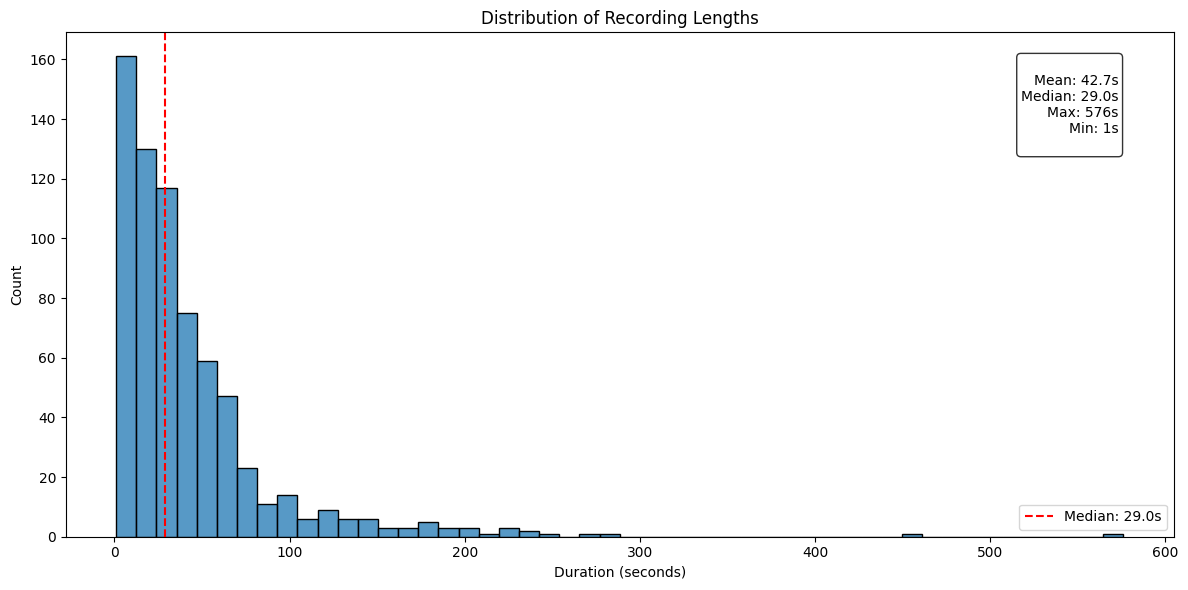

In [48]:
# Recording Length Distribution

# Create figure with larger size
plt.figure(figsize=(12, 6))

# Create main distribution plot
sns.histplot(data=data, x='length_seconds', bins=50)

# Add vertical line for median
plt.axvline(data['length_seconds'].median(), color='red', linestyle='--', label=f"Median: {data['length_seconds'].median():.1f}s")

# Customize plot
plt.title('Distribution of Recording Lengths', fontsize=12)
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.legend()

# Add text with summary statistics
stats_text = f"""
Mean: {data['length_seconds'].mean():.1f}s
Median: {data['length_seconds'].median():.1f}s
Max: {data['length_seconds'].max()}s
Min: {data['length_seconds'].min()}s
"""
plt.text(0.95, 0.95, stats_text, 
         transform=plt.gca().transAxes, 
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Apply NLP to 'remarks' column to attempt to extract valuable info

### Analyze 'sex'
Too many missing
too few females
dropping this column

In [31]:
data['sex'].value_counts()

sex
None            427
male            178
uncertain       127
female, male     17
female            7
Name: count, dtype: int64

### Analyze 'stage' 
too many missing
imbalanced to adults
drop this

In [32]:
data['stage'].value_counts()

stage
None               441
adult              267
uncertain           40
juvenile             7
adult, juvenile      1
Name: count, dtype: int64

### Analyze 'also' 
This column contains data that indicates what other species' noises are present in the recording

### Leave the 'also' column to be handled with the audio segmentation

In [33]:
data['also'].nunique()

324

In [34]:
data['also'].value_counts()

also
None                                                                                                                                                                    328
Agelaius phoeniceus                                                                                                                                                      29
Turdus migratorius                                                                                                                                                       11
Agelaius phoeniceus, Setophaga aestiva                                                                                                                                    7
Agelaius phoeniceus, Branta canadensis                                                                                                                                    6
                                                                                                                                       

There is 'Identity unknown' in common_name and 'mystery' in species. Let's remove these as we won't be able to use them without labels. However we can use this unidentified files to make predictions on with our final model.

In [35]:
# Create a boolean mask for unidentified entries
unidentified_mask = (data['common_name'] == 'Identity unknown') & (data['species'] == 'mystery')

# Save the unidentified entries to a CSV file
unidentified_data = data[unidentified_mask]
unidentified_data.to_csv('unidentified_data.csv', index=False)

# Remove the unidentified entries from the main dataframe
data = data[~unidentified_mask]

# Check for remaining 'Identity unknown' or 'mystery' entries
unknown_common = data['common_name'] == 'Identity unknown'
mystery_species = data['species'] == 'mystery'

# Count the occurrences
unknown_common_count = unknown_common.sum()
mystery_species_count = mystery_species.sum()

print(f"Entries with 'Identity unknown' common name: {unknown_common_count}")
print(f"Entries with 'mystery' species: {mystery_species_count}")
print(f"Number of unidentified entries saved to CSV: {len(unidentified_data)}")

Entries with 'Identity unknown' common name: 0
Entries with 'mystery' species: 0
Number of unidentified entries saved to CSV: 64


In [36]:
# Get the top 30 most common names
top_30_names = data['common_name'].value_counts().nlargest(30).index

# Filter the dataframe to keep only entries with these top 30 names
filtered_data = data[data['common_name'].isin(top_30_names)]

# Get the number of entries in the filtered dataframe
num_entries_after_filter = len(filtered_data)

print(f"Original number of entries: {len(data)}")
print(f"Number of entries after filtering for top 30 most common names: {num_entries_after_filter}")

Original number of entries: 692
Number of entries after filtering for top 30 most common names: 346


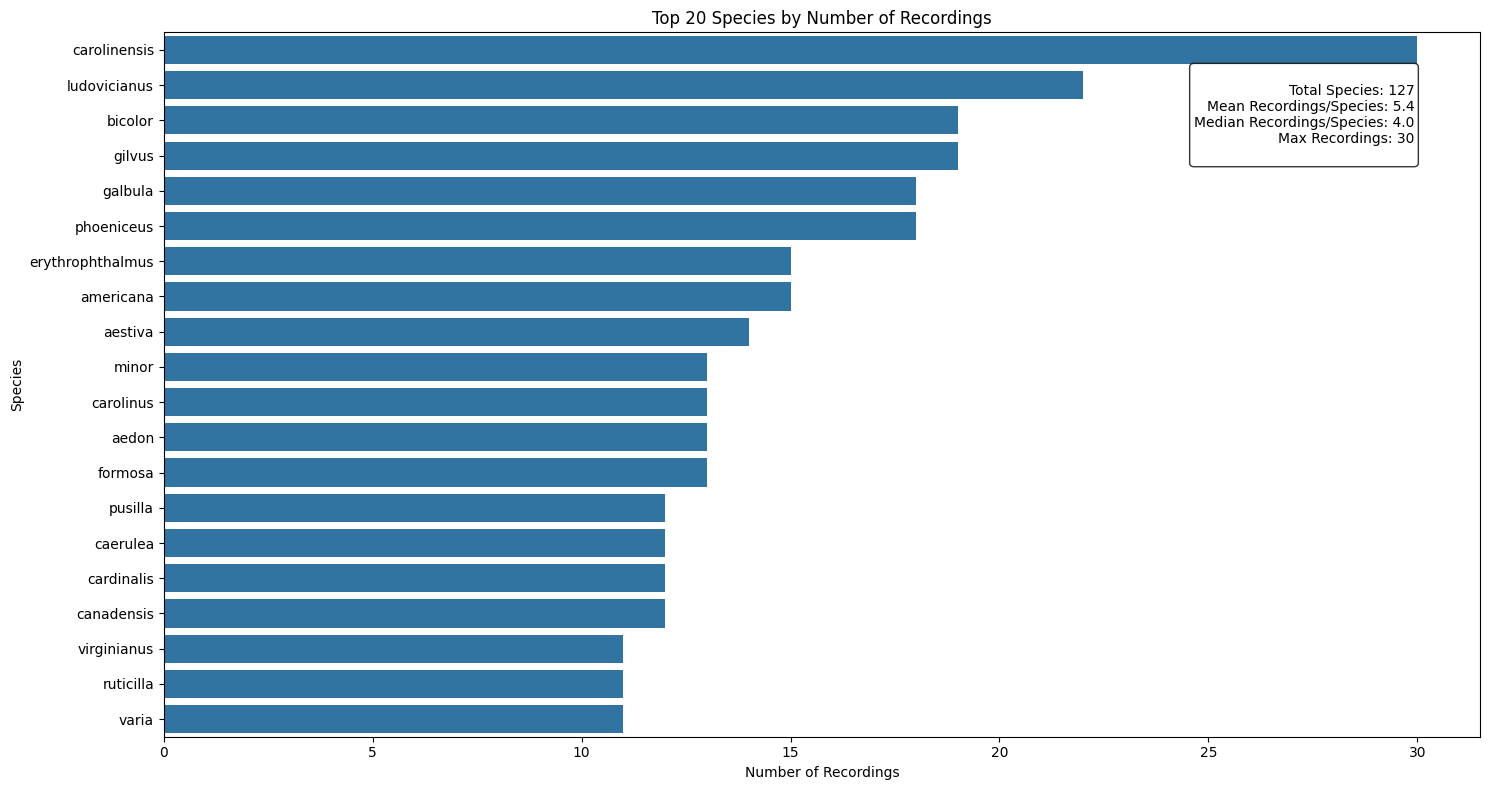

In [50]:
# Species Frequency Distribution
plt.figure(figsize=(15, 8))

# Get species counts
species_counts = data['species'].value_counts()

# Create bar plot
sns.barplot(x=species_counts.values[:20], y=species_counts.index[:20])

plt.title('Top 20 Species by Number of Recordings', fontsize=12)
plt.xlabel('Number of Recordings')
plt.ylabel('Species')

# Add text with summary statistics
stats_text = f"""
Total Species: {len(species_counts)}
Mean Recordings/Species: {species_counts.mean():.1f}
Median Recordings/Species: {species_counts.median():.1f}
Max Recordings: {species_counts.max()}
"""
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

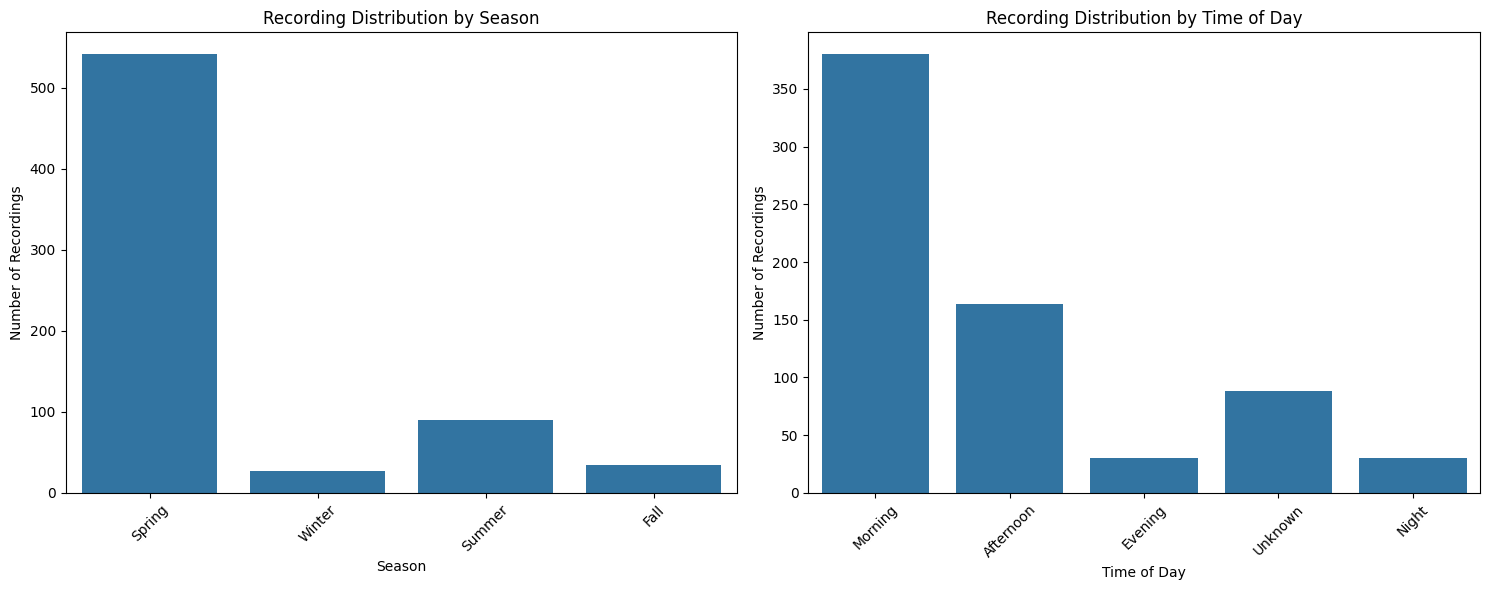

In [52]:
# Create subplot for both seasonal and daily patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Seasonal distribution
sns.countplot(data=data, x='season', ax=ax1)
ax1.set_title('Recording Distribution by Season')
ax1.set_xlabel('Season')
ax1.set_ylabel('Number of Recordings')
ax1.tick_params(axis='x', rotation=45)

# Time of day distribution
sns.countplot(data=data, x='time_of_day', ax=ax2)
ax2.set_title('Recording Distribution by Time of Day')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Number of Recordings')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

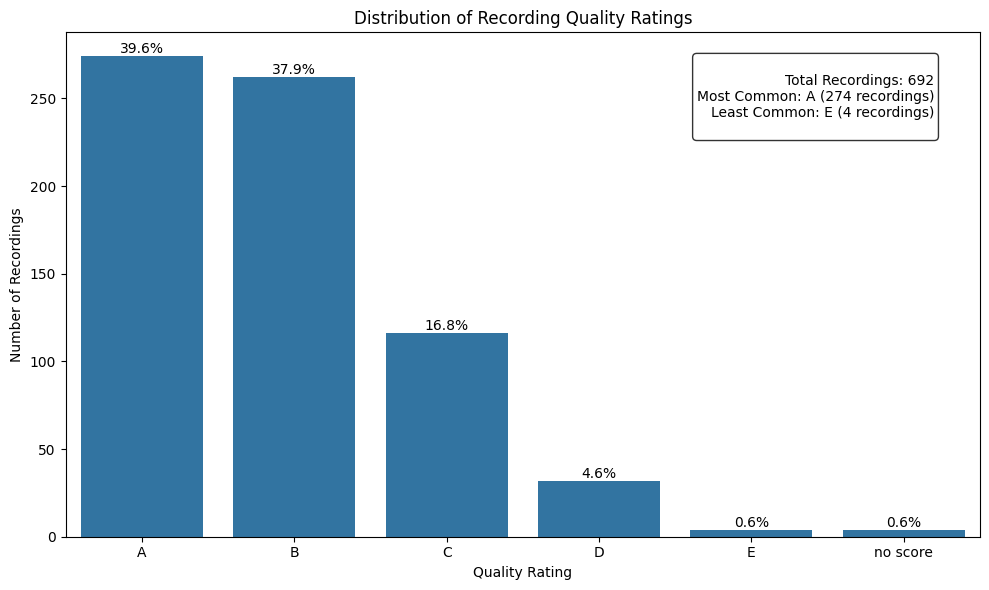

In [53]:
# Quality Rating Distribution
plt.figure(figsize=(10, 6))

# Create count plot
quality_counts = data['quality'].value_counts().sort_index()
sns.barplot(x=quality_counts.index, y=quality_counts.values)

plt.title('Distribution of Recording Quality Ratings', fontsize=12)
plt.xlabel('Quality Rating')
plt.ylabel('Number of Recordings')

# Add percentage labels on top of each bar
total = len(data)
for i, v in enumerate(quality_counts.values):
    percentage = v/total * 100
    plt.text(i, v, f'{percentage:.1f}%', 
             horizontalalignment='center',
             verticalalignment='bottom')

# Add summary text
stats_text = f"""
Total Recordings: {total}
Most Common: {quality_counts.index[quality_counts.argmax()]} ({quality_counts.max()} recordings)
Least Common: {quality_counts.index[quality_counts.argmin()]} ({quality_counts.min()} recordings)
"""
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [37]:
top_25_birds = data['common_name'].value_counts().nlargest(25)

fig = px.bar(
    x=top_25_birds.index,
    y=top_25_birds.values,
    labels={'x': 'Bird Species', 'y': 'Frequency'},
    title='Top 25 Most Frequent Bird Species',
    color=top_25_birds.values,
    color_continuous_scale='viridis'
)

fig.update_layout(
    font=dict(family="Arial", size=14),
    plot_bgcolor='white',
    xaxis=dict(
        tickangle=45,
        title_font=dict(size=16),
        tickfont=dict(size=12),
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title_font=dict(size=16),
        tickfont=dict(size=12),
        gridcolor='lightgray'
    ),
    coloraxis_colorbar=dict(title='Frequency'),
    title=dict(font=dict(size=24)),
    height=800,
    width=1200
)

fig.show()

In [38]:
# Create the map
fig = px.scatter_mapbox(data, 
                        lat='latitude', 
                        lon='longitude', 
                        hover_name='common_name', 
                        hover_data=['length_seconds'],  # Additional info for hover
                        color='common_name',  # Color points by bird species
                        zoom=7,  # Adjust zoom level to fit Ohio
                        height=800,
                        width=1000,
                        title='Bird Recording Locations in Ohio')

# Update the map layout
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": 40.4173, "lon": -82.9071},  # Center of Ohio
    margin={"r":0,"t":50,"l":0,"b":0},
    title={
        'text': "Bird Recording Locations in Ohio",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    legend_title_text='Bird Species',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Show the map

fig.show()

# Drop Uninformative columns and columns that have been processed

In [39]:
preprocessed_data = data.drop(columns=['id', 'common_name','sex', 'date','time','length','remarks','also','stage','type'])

preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692 entries, 0 to 691
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   genus            692 non-null    object 
 1   species          692 non-null    object 
 2   latitude         692 non-null    float64
 3   longitude        692 non-null    float64
 4   quality          692 non-null    object 
 5   file_name        692 non-null    object 
 6   simplified_type  692 non-null    object 
 7   season           692 non-null    object 
 8   time_of_day      692 non-null    object 
 9   length_seconds   692 non-null    int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 59.5+ KB


In [42]:
preprocessed_data['species'].nunique()

127

In [44]:
preprocessed_data['simplified_type'].value_counts()

simplified_type
Song       497
Call       182
Other        7
Unknown      6
Name: count, dtype: int64

In [40]:
preprocessed_data['file_name'].value_counts()

file_name
Branta_canadensis_Whitewater_Township_near__Harrison_Hamilton_County_Ohio_726750.mp3                 1
Molothrus_ater_Lawrence_Woods_SNP_417996.mp3                                                         1
Agelaius_phoeniceus_Crosby_Township_near__Harrison_Hamilton_County_Ohio_482675.mp3                   1
Agelaius_phoeniceus_Case_Farm_Gates_Mills_Ohio_98722.mp3                                             1
Agelaius_phoeniceus_Ohio_Crane_Creek_SP_17011.mp3                                                    1
                                                                                                    ..
Tachycineta_bicolor_Pelee_Shuttle_Stop_near__Leamington_Essex_County_Ontario_477045.mp3              1
Tachycineta_bicolor_Ohio_Crane_Creek_SP_17046.mp3                                                    1
Progne_subis_Vermilion_River_Reservation:_Mill_Hollow_near__Vermilion_Erie_County_Ohio_784046.mp3    1
Progne_subis_Ottawa_NWR_Lucas_County_Ohio_803616.mp3           

In [41]:
preprocessed_data.to_csv("preprocessed_data.csv",index=False)